# JHU covid-19 daily data processing 

Test and update functions for JHU data analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import glob
import os
 
import matplotlib.ticker as mticker
import matplotlib.dates as mdates 

from datetime import timedelta 
import datetime
import pytz
from tzwhere import tzwhere  


from matplotlib.dates import date2num       #-->Update

import matplotlib
from matplotlib import cm


import os
import sys
base_path = os.path.dirname( os.getcwd()  )   
sys.path.append(base_path ) 
import JHU_dataprocessing_functions as dp
import JHU_plotting_functions as jp 

# general parameters 

In [2]:
full_w = (12,7)
half_w = (6,4)

# Load daily reports 

In [3]:
path = r'D:\Code_projects\Covid19_analysis\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports'

daily_reports = glob.glob(path + '\*.csv') 
df = pd.DataFrame()
for file in daily_reports :
    df_temp = pd.read_csv( file, index_col=None, header=0) 
    df = df.append(df_temp, sort=True) 

df.tail()

,Active,Admin2,Combined_Key,Confirmed,Country/Region,Country_Region,Deaths,FIPS,Last Update,Last_Update,Lat,Latitude,Long_,Longitude,Province/State,Province_State,Recovered
3094,391.0,NaN,West Bank and Gaza,466.0,NaN,West Bank and Gaza,4.0,NaN,NaN,2020-04-21 23:30:30,31.952200,NaN,35.233200,NaN,NaN,NaN,71.0
3095,6.0,NaN,Western Sahara,6.0,NaN,Western Sahara,0.0,NaN,NaN,2020-04-21 23:30:30,24.215500,NaN,-12.885800,NaN,NaN,NaN,0.0
3096,1.0,NaN,Yemen,1.0,NaN,Yemen,0.0,NaN,NaN,2020-04-21 23:30:30,15.552727,NaN,48.516388,NaN,NaN,NaN,0.0
3097,32.0,NaN,Zambia,70.0,NaN,Zambia,3.0,NaN,NaN,2020-04-21 23:30:30,-13.133897,NaN,27.849332,NaN,NaN,NaN,35.0
3098,23.0,NaN,Zimbabwe,28.0,NaN,Zimbabwe,3.0,NaN,NaN,2020-04-21 23:30:30,-19.015438,NaN,29.154857,NaN,NaN,NaN,2.0


# adjust column names and use only relevant columns

In [4]:
# convert different datetimes to same datetime column 
df['Last Update'] = pd.to_datetime(df['Last Update']   )
df['Last_Update'] = pd.to_datetime(df['Last_Update']   )   #  
cond = df['Last_Update'].isnull()
df['Last Update'] = df['Last Update'].where(cond, df['Last_Update'] ) 
df['Datetime']= pd.to_datetime(df['Last Update'] , unit='D'   ) 
df['Date'] = df['Datetime'].dt.date

cond = df['Country_Region'].isnull()
df['Country/Region'] = df['Country/Region'].where(cond, df['Country_Region'] ) 

cond = df['Province_State'].isnull()
df['Province/State'] = df['Province/State'].where(cond, df['Province_State'] ) 
 
col_order = ['Date','Country/Region','Province/State','Active','Confirmed','Deaths','Recovered','Combined_Key' ]
df = df[col_order]

df.tail()

,Date,Country/Region,Province/State,Active,Confirmed,Deaths,Recovered,Combined_Key
3094,2020-04-21,West Bank and Gaza,NaN,391.0,466.0,4.0,71.0,West Bank and Gaza
3095,2020-04-21,Western Sahara,NaN,6.0,6.0,0.0,0.0,Western Sahara
3096,2020-04-21,Yemen,NaN,1.0,1.0,0.0,0.0,Yemen
3097,2020-04-21,Zambia,NaN,32.0,70.0,3.0,35.0,Zambia
3098,2020-04-21,Zimbabwe,NaN,23.0,28.0,3.0,2.0,Zimbabwe


# process columns 

In [5]:
bool_US = df['Country/Region'] =='US' 
# bool_last = df['Date'] > datetime.datetime(2020,3,22).date() 
bool_last = df['Date'] > datetime.datetime(2020,3,23).date()
 
df_US = df[bool_US & bool_last ].copy() 
 
df_US =  df_US.groupby(['Province/State','Date']).sum().reset_index()  
df_US = df_US.sort_values( by=['Province/State','Date']).reset_index(drop=True)  
 
df_US.head()
 

,Province/State,Date,Active,Confirmed,Deaths,Recovered
0,Alabama,2020-03-24,0.0,242.0,0.0,0.0
1,Alabama,2020-03-25,0.0,381.0,1.0,0.0
2,Alabama,2020-03-26,0.0,517.0,1.0,0.0
3,Alabama,2020-03-27,0.0,587.0,4.0,0.0
4,Alabama,2020-03-28,0.0,694.0,4.0,0.0


# transform state geometry 

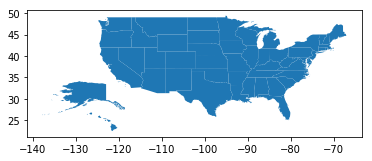

In [6]:
import geopandas as gpd

    
data_path = os.path.join(  base_path,  'geo_data\states.shp' )  
US = gpd.read_file(data_path)
AKratio = 0.4;  # scales Alaska 
HIratio = 1.3 # scales Hawai 
AKtrans = [25,-33] # moves Alaska south and east 
HItrans = [34,4] # moves Hawaii east and north 
 
import shapely.affinity as shp

# get original polygons
bool_alaska = US['STATE_NAME'] == 'Alaska'
alaska_object = US.loc[bool_alaska,'geometry']
alaska_geom = US.loc[bool_alaska,'geometry'].iloc[0] 

alaska_moved = shp.translate(alaska_geom, AKtrans[0], AKtrans[1])  
centroid = alaska_moved.centroid
alaska_scaled = shp.scale( alaska_moved, xfact=AKratio, yfact=AKratio, origin=centroid)
# US['geometry'][50] =  alaska_scaled
alaska_object.iloc[0] = alaska_scaled
US.loc[bool_alaska,'geometry'] = alaska_object

# # US['geometry'][50] =  alaska_scaled

bool_hawaii = US['STATE_NAME'] == 'Hawaii'
hawaii_obj = US.loc[bool_hawaii,'geometry']
hawaii_geom = hawaii_obj.iloc[0]

hawaii_moved = shp.translate(hawaii_geom, HItrans[0], HItrans[1])  
centroid = hawaii_moved.centroid
hawaii_scaled = shp.scale( hawaii_moved, xfact=HIratio, yfact=HIratio, origin=centroid)
hawaii_obj.iloc[0] = hawaii_scaled

US.loc[bool_hawaii,'geometry'] =  hawaii_obj

  
 
US.plot()
 

In [7]:
# type( US.loc[bool_alaska,'geometry']  )
alaska_obj = US.loc[bool_alaska,'geometry']

geom = alaska_obj.iloc[0]

alaska_obj.iloc[0] = geom
alaska_obj 
# US['geometry'] 

50    (POLYGON ((-131.076298949224 29.08360244818114...
Name: geometry, dtype: object

In [11]:
();

df_US

#     bool_US = US['STATE_NAME'] == state 
# #     US.loc[bool_US,'Cases'] = latest_cases  
#     US.loc[bool_US,'Cases'] = np.log(latest_cases+1) 

US.head()



# states = US['STATE_NAME'].tolist()
dates = df_US['Date'].unique()  

bool_prior = df_US['Date'] == dates[-7] 
states = df_US.loc[bool_prior,'Province/State'].unique().tolist()

for state in states: 
    print(state)
    bool_state = df_US['Province/State'] == state 
    bool_date = df_US['Date'] == dates[-1]
    bool_prior = df_US['Date'] == dates[-7] 
    if (bool_state & bool_date).sum() > 0:
        now_cases = df_US[bool_state & bool_date ]['Confirmed'].iloc[0]
        prior_cases = df_US[bool_state & bool_prior ]['Confirmed'].iloc[0]
        latest_cases = (now_cases-prior_cases)/7
    else:
        latest_cases = 0 
         
    df_US.loc[bool_state ,'Cases'] = np.log(latest_cases + 2)
    
    
# US['Cases'] = 0 
df_US = df_US.rename(columns={'Province/State':'STATE_NAME'}) 

df_US = df_US[bool_date] 
US= pd.merge(US, df_US, how='left', on=['STATE_NAME'])
df_US.head()  

Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
Diamond Princess
District of Columbia
Florida
Georgia
Grand Princess
Guam
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Northern Mariana Islands
Ohio
Oklahoma
Oregon
Pennsylvania
Puerto Rico
Recovered
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virgin Islands
Virginia
Washington
West Virginia
Wisconsin
Wyoming


,STATE_NAME,Date,Active,Confirmed,Deaths,Recovered,Cases
28,Alabama,2020-04-21,5134.0,5317.0,183.0,0.0,5.189777
57,Alaska,2020-04-21,320.0,329.0,9.0,0.0,1.966113
93,Arizona,2020-04-21,5048.0,5256.0,208.0,0.0,5.228814
122,Arkansas,2020-04-21,1948.0,1990.0,42.0,0.0,4.129436
151,California,2020-04-21,34183.0,35465.0,1282.0,0.0,7.135801


# plot US map

In [ ]:
# fig, ax = plt.subplots(1,1 ,figsize=(15,8))
fig, ax = plt.subplots(1,1 ,figsize=half_w )


wp = US.plot(column='Cases', ax=ax, cmap='OrRd'   );

wp.set_xbound(-135,-66)
wp.set_ybound(20,49.5)  
 

vmin =    US['Cases'].min()
vmax =  ( US['Cases'].max() )
 
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax)) 
 



# fake up the array of the scalar mappable. Urgh...
sm._A = []
cax = fig.add_axes([0.2, 0.25, 0.6, 0.03])
cb = fig.colorbar(sm, cax=cax, orientation='horizontal')
 

# tick_array =  [1,10,100,1000,10000,10000] 
tick_array =  [20,40,100,400,1000,4000,10000 ] 
log_cases = np.log( tick_array  )  
cb.set_ticks( log_cases ) 
cb.set_ticklabels( tick_array) 
cb.set_label(' Daily case increaes  \n (average over last 7 days)')

ax.axis("off")


ax.annotate('Updated '+str( df_US['Date'].iloc[-1]), 
            [-135,22 ], color=[.3,.3,.3], style='italic',fontsize=8)
 